### Predicting West Nile Virus in Chicago

This project was to predict the probability that a mosquito trap in Chicago will have captured a mosquito with West Nile Virus (WNV). This is a closed competition on Kaggle, but still accepts submissions and will tell you where your submission would have ranked and what your area under the curve (AUC) score would be on the test data set.

The training data contains information on if WNV was present in a trap when it was checked in 2007, 2009, 2011, and 2013, along with the date it was checked, the species of mosquito that were found, and the number of mosquitos found. This was tested against data from 2008, 2010, 2012, and 2014, with the same information included except for if West Nile Virus was present when the trap was checked and the number of mosquitos in a trap.

First, we need to read in our data and import all necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import cross_val_score, StratifiedKFold , train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

# cleaning up the notebook
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/Users/jcarr/downloads/train.csv')

The data given requires several transformations. The date field needed to be turned into a datetime from a string, and then month, year, and week number (i.e. the first week in a given month, second week, etc) extracted from that.

The main transformation that needed to take place was to count the number of records for traps that were checked on a given day. The competition did not provide the number of mosquitos that were found in a trap in the test data, but it was included in the training data. However, from reviewing the number of mosquitos listed in the training data it was determined that the total number of records for a trap on a given day could be used as a proxy for the number of mosquitos in a trap. Each row represents a group of 50 mosquitos. If a trap was checked and had 150 mosquitos in it, this data would be presented in 3 rows, with 3 separate groups of 50 mosquitos evaluated for the presence of WNV. While the number of mosquitos was not made available as part of the test set, counting the number of records for a trap on a given day provides us with a suitable proxy for number of mosquitos found in a trap.

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df.Date.apply(lambda x: x.month)
df['year'] = df.Date.apply(lambda x: x.year)
df['WkNb'] = df.Date.apply(lambda x: float(x.strftime("%U")))
df['Trap'] = df.Trap.str[:4]

## Create column w just '1' in each column to sum and weight traps with more mosquitos

df['weight'] = 1

## Sum of traps having WNV by month, put in new DFs

df_2 = df.groupby(['Date','Trap']).weight.sum().reset_index()

df_target = df.groupby(['Date','Trap']).WnvPresent.max().reset_index()

## extract month and year from date format

df_2['Date'] = pd.to_datetime(df_2['Date'])
df_2['month'] = df_2.Date.apply(lambda x: x.month)
df_2['year'] = df_2.Date.apply(lambda x: x.year)
df_2['WkNb'] = df_2.Date.apply(lambda x: float(x.strftime("%U")))

After the transformations above, my partner and I decided to assign weights to traps based on the prevalence of WNV in a given trap in the years that we knew WNV was there. (Note - this was a bit of a hack given that this was a Kaggle competition. This likely would not have been as good of an option if the competition was not set up this way, but it proved to be effective for our purposes). We assigned a weight based on the number of rows that did have WNV present out of the number that had no WNV present within a given month over the 4 years of data. The first few rows of this weighted data are output by the cell below.

In [4]:
## get weight of traps by month... num of records w wnv present over total records for trap and month

df_test = df.groupby(['Date','Trap','Species','WnvPresent']).weight.sum().reset_index()

## Same conversions for date
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test['month'] = df_test.Date.apply(lambda x: x.month)
df_test['year'] = df_test.Date.apply(lambda x: x.year)

df_test_2 = df_test.groupby(['Trap','month','WnvPresent']).weight.sum().reset_index()
df_test_2_full = df_test_2.groupby(['Trap','month']).weight.sum().reset_index()
df_test_2_y = df_test_2[df_test_2.WnvPresent == 1].groupby(['Trap','month']).weight.sum().reset_index()

df_test_2_y.rename(columns={'weight':'WNV'}, inplace = True)

df_ratio = pd.merge(df_test_2_full, df_test_2_y, how = 'left', on = ['Trap','month'])
df_ratio.fillna(0, inplace = True)
df_ratio['WNV_ratio'] = df_ratio.WNV / df_ratio.weight
df_ratio.head(15)

,Trap,month,weight,WNV,WNV_ratio
0,T001,6,1,0.0,0.000000
1,T001,7,2,0.0,0.000000
2,T001,8,9,0.0,0.000000
3,T001,9,1,0.0,0.000000
4,T001,10,2,0.0,0.000000
5,T002,5,3,0.0,0.000000
6,T002,6,37,0.0,0.000000
7,T002,7,65,1.0,0.015385
8,T002,8,45,12.0,0.266667
9,T002,9,32,5.0,0.156250


The cell below was also done because the task was a Kaggle competition. In an effort to increase our model's AUC and prevent any false positives from occurring, we manually assigned certain traps a predicted probability of zero. These were traps that never caught a mosquito with WNV in the 4 years of training data, as well as the 3 months of the year that either never had a trap with WNV, or in the case of June and October, had at most 2 traps over the 4 year period where a trap caught a mosquito with WNV.

In [5]:
## Automatically set specific probabilities to zero

null_traps = df_test_2_y.groupby(['Trap']).WNV.sum().reset_index()
null_traps.rename(columns={'WNV':'WnvEver'}, inplace = True)
df_ratio = pd.merge(df_ratio, null_traps, how = 'left', on = ['Trap'])

## Adjust weight - max ratio is 0.5, so adding 0.5 to make at least some probabilities = 1
#df_ratio_2['WNV_ratio'] = df_ratio_2.WNV_ratio + 0.5

df_ratio.loc[df_ratio.WnvEver == 0, 'WNV_ratio'] = 0.0

df_ratio.loc[df_ratio.month == 5, 'WNV_ratio'] = 0.0
df_ratio.loc[df_ratio.month == 6, 'WNV_ratio'] = 0.0
df_ratio.loc[df_ratio.month == 10, 'WNV_ratio'] = 0.0


In [6]:
## Encode traps, since they are categorical values
le = LabelEncoder()
traps = le.fit_transform(df_ratio.Trap)
traps = pd.DataFrame(data = traps, columns = ['Trap_Encode'])

df_ratio_2 = pd.concat([df_ratio, traps], axis = 1)

## Joining predicted probabilities to original dataframe w West Nile predictions

prob_pred = pd.merge(df, df_ratio_2, how = 'left', on = ['Trap','month'])

In [18]:
### Transforming Kaggle submission file below

test = pd.read_csv('/Users/jcarr/downloads/test.csv')

traps = le.fit_transform(test.Trap)
traps = pd.DataFrame(traps, columns = ['Trap_Encode'])

test['Date'] = pd.to_datetime(test['Date'])
test['month'] = test.Date.apply(lambda x: x.month)
test['year'] = test.Date.apply(lambda x: x.year)
test['WkNb'] = test.Date.apply(lambda x: float(x.strftime("%U")))
test['Trap'] = test.Trap.str[:4]
test = pd.concat([test, traps], axis = 1)
test = pd.merge(test, df_ratio, how = 'left', on = ['Trap','month'])
test.head()


test.loc[test.WnvEver == 0, 'WNV_ratio'] = 0.0
test.loc[test.Species.str.contains('SALINARIUS'), 'WNV_ratio'] = 0.0
test.loc[test.Species.str.contains('TERRITANS'), 'WNV_ratio'] = 0.0
test.loc[test.Species.str.contains('TARSALIS'), 'WNV_ratio'] = 0.0
test.loc[test.Species.str.contains('ERRATICUS'), 'WNV_ratio'] = 0.0
test.loc[test.Species.str.contains('UNSPECIFIED'), 'WNV_ratio'] = 0.0

test.loc[test.month == 5, 'WNV_ratio'] = 0.0
test.loc[test.month == 6, 'WNV_ratio'] = 0.0
test.loc[test.month == 10, 'WNV_ratio'] = 0.0

In [19]:
test['weight'] = 1

## Calculate rates of traps having WNV by month, put in new DFs

test_weight = test.groupby(['month','year','Trap']).weight.sum().reset_index()
test_weight.rename(columns = {'weight': 'leakage'}, inplace = True)

In [20]:
test_2 = pd.merge(test, test_weight, how = 'left', on = ['month','year','Trap'])
test_2['WNV_ratio_2'] = test_2.WNV_ratio * test_2.leakage
test_2.fillna(0, inplace = True)

XGBoost, a gradient-boosted decision tree classifier, provided us with the best scores as determined by AUC. We attempted using a Random Forest Classifier, as well as just using our created weighted trap value as the probability that a trap had WNV at the point it was checked. The process to create predictions with the XGBoost model is below.

The features used are the trap, month, year, and week checked, latitude and longitude, and then the weighted value that was calculated for each trap.

In [8]:
X_train = prob_pred[['Trap_Encode', 'month', 'year', 'WNV_ratio', 'Latitude', 'Longitude', 'WkNb']]
y_train = prob_pred.WnvPresent

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5], 'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1)

The code above selected the best parameters from the grid search, and now it is fit to the training data below.

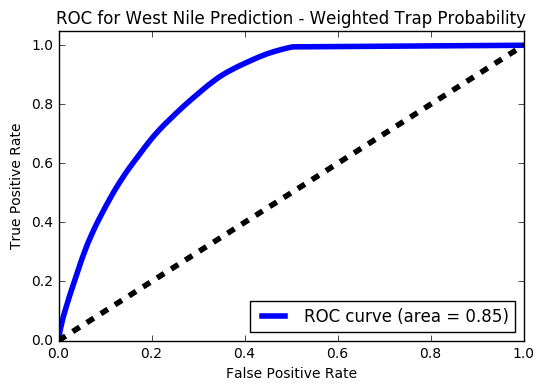

In [11]:
actual = prob_pred.WnvPresent
ratio = prob_pred.WNV_ratio

FPR = dict()
TPR = dict()
ROC_AUC = dict()


# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(actual, ratio)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for West Nile Prediction - Weighted Trap Probability')
plt.legend(loc="lower right")
plt.show()

In [9]:
optimized_GBM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.7, 0.8, 0.9], 'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

Below, the same transformations are applied to the test data that Kaggle uses to score the model, and the file is created that is submitted to Kaggle for scoring.

In [23]:
X_test = test_2[['Trap_Encode', 'month', 'year', 'WNV_ratio', 'Latitude', 'Longitude', 'WkNb']]
results = optimized_GBM.predict_proba(X_test)

In [28]:
xgbres = pd.DataFrame(results[:,1], columns=['xgbres'])
final = test_2.join(xgbres)

p = []

p = pd.DataFrame(p)
p['Id'] = final.Id
p['WnvPresent'] = final.xgbres

The results from dataframe 'p' are what was submitted to Kaggle - a unique record indicating which trap was checked and when, and the probability it contained WNV.
```python
p.to_csv('submission.csv', index=False)
```